In [1]:
# import packages
import h5py
import numpy as np
import torch
from mirtorch.linear import NuSense, NuSenseGram, Diff3dgram, Diag
from mirtorch.alg import CG
import os
import sys
from recutl import mri_coil_compress, resize_nd

In [ ]:
# set variables
gpu_idx = 2 # GPU index for CUDA (-1 = CPU)
fname_kdata = '/home/djfrey/data/lps_fmri_20250411/lps_struct.h5' # name of the GRE data file
fname_smaps = os.path.join(os.path.dirname(fname_kdata), 'smaps.h5') # name of the smaps file
ncoil_comp = 4 # number of virtual coils to compress to
cutoff = 0.85 # kspace cutoff for echo-in/out filtering
rolloff = 0.2 # kspace rolloff for echo-in/out filtering
lam = 0.15 # regularization parameter for quadratic differencing penalty
niter = 20 # number of iterations for CG
M = None # reconstructed matrix size (None = N*cutoff)
ints2use = None # interleaf indices to use (None = all)
prjs2use = 500 # projection indices to use (None = all)
reps2use = None # repetition indices to use (None = all)
volwidth = None # number of projections per volume (None = use each rep as a volume)
use_toeplitz = True # use Toeplitz approximation of forward model
mem_save = True # only use GPU for forward model (slower but less memory)

In [3]:
# select device
if torch.cuda.is_available() & (gpu_idx >= 0):
    device0 = torch.device(f'cuda:{gpu_idx}')
else:
    device0 = torch.device('cpu')
print(f'using device: {device0}')

using device: cuda:2


In [4]:
# load in the data
with h5py.File(fname_kdata, 'r') as h5_file:
    kdata = h5_file['kdata/real'][:] + 1j * h5_file['kdata/imag'][:] # kspace data
    k_in = h5_file['ktraj/spoke_in'][:] # kspace spoke-in trajectory (1/cm)
    k_out = h5_file['ktraj/spoke_out'][:] # kspace spoke-out trajectory (1/cm)
    fov = h5_file['seq_args/fov'][0][0] # field of view (cm)
    N = int(h5_file['seq_args/N'][0][0]) # 3D matrix size
    nseg = int(h5_file['seq_args/nseg'][0][0]) # number of points per segment
    nspokes = int(h5_file['seq_args/nspokes'][0][0]) # number of spokes
    nprj = int(h5_file['seq_args/nprj'][0][0]) # number of projections
    nint = int(h5_file['seq_args/nint'][0][0]) # number of interleaves
    nrep = int(h5_file['seq_args/nrep'][0][0]) # number of repetitions
    ncoil = int(h5_file['ncoil'][0][0]) # number of coils

# convert to tensors
kdata = torch.tensor(kdata).reshape(ncoil,nrep,nprj,nint,nseg*nspokes)
k_in = torch.tensor(k_in).reshape(3,nrep,nprj,nint,nseg*nspokes)
k_out = torch.tensor(k_out).reshape(3,nrep,nprj,nint,nseg*nspokes)

In [5]:
# set default values for interleaves, projections, and repetitions to use
if ints2use is None:
    ints2use = nint
if prjs2use is None:
    prjs2use = nprj
if reps2use is None:
    reps2use = nrep
if volwidth is None:
    volwidth = prjs2use*ints2use

# get number of volumes
nvol = reps2use*prjs2use*ints2use // volwidth

# arrange data into volumes
kdata2 = kdata.clone()
kdata2 = kdata2[:,np.arange(reps2use),:,:,:]
kdata2 = kdata2[:,:,np.arange(prjs2use),:,:]
kdata2 = kdata2[:,:,:,np.arange(ints2use),:]
kdata2 = kdata2.reshape(ncoil,reps2use*prjs2use*ints2use,nseg*nspokes)
kdata2 = kdata2[:,:nvol*volwidth,:]
kdata2 = kdata2.reshape(ncoil,nvol,volwidth*nseg*nspokes)
kdata2 = kdata2.permute(1,0,2)

# arrange kspace trajectory into volumes
k_in2 = k_in.clone()
k_in2 = k_in2[:,np.arange(reps2use),:,:,:]
k_in2 = k_in2[:,:,np.arange(prjs2use),:,:]
k_in2 = k_in2[:,:,:,np.arange(ints2use),:]
k_in2 = k_in2.reshape(3,reps2use*prjs2use*ints2use,nseg*nspokes)
k_in2 = k_in2[:,:nvol*volwidth,:]
k_in2 = k_in2.reshape(3,nvol,volwidth*nseg*nspokes)
k_in2 = k_in2.permute(1,0,2)

k_out2 = k_out.clone()
k_out2 = k_out2[:,np.arange(reps2use),:,:,:]
k_out2 = k_out2[:,:,np.arange(prjs2use),:,:]
k_out2 = k_out2[:,:,:,np.arange(ints2use),:]
k_out2 = k_out2.reshape(3,reps2use*prjs2use*ints2use,nseg*nspokes)
k_out2 = k_out2[:,:nvol*volwidth,:]
k_out2 = k_out2.reshape(3,nvol,volwidth*nseg*nspokes)
k_out2 = k_out2.permute(1,0,2)

# calculate reconstructed matrix size
if M is None:
    M = int(np.ceil(N*cutoff))

In [6]:
# load in the sensitivity maps
with h5py.File(fname_smaps, 'r') as h5_file:
    smaps = torch.tensor(h5_file['/real'][:] + 1j * h5_file['/imag'][:]).unsqueeze(0).to(kdata) # kspace data
smaps = resize_nd(smaps, (2,3,4), M/smaps.shape[2]) # resize to match kspace data
smaps = smaps.permute(0,1,4,3,2)

In [7]:
# coil compress the data
kdata_comp,Vr = mri_coil_compress(kdata2, ncoil=ncoil_comp)

# coil compress the sensitivity maps
smaps_comp,_ = mri_coil_compress(smaps, Vr=Vr)

In [ ]:
# convert trajectory to spatial frequencies
om_in = 2*torch.pi * fov/M * k_in2
om_out = 2*torch.pi * fov/M * k_out2

# create kspace filter
r_cut = cutoff * N/M * torch.pi
r_roll = rolloff * N/M * torch.pi
kfilt = lambda r: (r <= r_cut) * 1/(1 + torch.exp(2*torch.pi * (r - r_cut)/r_roll))
Hvec_in = kfilt(torch.norm(om_in,2,dim=1,keepdim=True)).repeat(1,ncoil_comp,1)
Hvec_out = kfilt(torch.norm(om_out,2,dim=1,keepdim=True)).repeat(1,ncoil_comp,1)

# set up system matrices
if mem_save:
    H_in = Diag(Hvec_in)
    H_out = Diag(Hvec_out)
    FS_in = NuSense(smaps_comp, om_in, nbatch=nvol, device=device0)
    FS_out = NuSense(smaps_comp, om_out, nbatch=nvol, device=device0)
    y = kdata_comp
    x0 = torch.zeros(nvol,1,M,M,M).to(y)
else:
    H_in = Diag(Hvec_in.to(device0))
    H_out = Diag(Hvec_out.to(device0))
    FS_in = NuSense(smaps_comp.to(device0), om_in.to(device0), nbatch=nvol)
    FS_out = NuSense(smaps_comp.to(device0), om_out.to(device0), nbatch=nvol)
    y = kdata_comp.to(device0)
    x0 = torch.zeros(nvol,1,M,M,M).to(y).to(device0)
A = H_in*FS_in + H_out*FS_out

# set up the gram matrix and RHS of normal equations
if use_toeplitz:
    if mem_save:
        G_in = NuSenseGram(smaps_comp, om_in, kweights=Hvec_in, nbatch=nvol, device=device0)
        G_out = NuSenseGram(smaps_comp, om_out, kweights=Hvec_out, nbatch=nvol, device=device0)
    else:
        G_in = NuSenseGram(smaps_comp.to(device0), om_in.to(device0), kweights=Hvec_in.to(device0), nbatch=nvol)
        G_out = NuSenseGram(smaps_comp.to(device0), om_out.to(device0), kweights=Hvec_out.to(device0), nbatch=nvol)
    AHA = G_in + G_out + 2*(H_in*FS_in).H*(H_out*FS_out)
else:
    AHA = A.H * A
AHy = A.H * y

# add L2 roughness penalty
THT = Diff3dgram(FS_in.size_in)
AHA_tikh = AHA + lam*THT

# set up the CG solver
solv = CG(AHA_tikh, max_iter=niter)

In [ ]:
# solve with CG
x = solv.run(x0, AHy)

INFO:mirtorch.alg.cg:Residual at 1th iter in forward CG:  8.538e+13.
INFO:root:GPU memory usage at 1th iter in CG backpropagation:  0.000e+00.
INFO:mirtorch.alg.cg:Residual at 2th iter in forward CG:  4.549e+13.
INFO:root:GPU memory usage at 2th iter in CG backpropagation:  0.000e+00.
INFO:mirtorch.alg.cg:Residual at 3th iter in forward CG:  1.963e+13.
INFO:root:GPU memory usage at 3th iter in CG backpropagation:  0.000e+00.
INFO:mirtorch.alg.cg:Residual at 4th iter in forward CG:  7.527e+12.
INFO:root:GPU memory usage at 4th iter in CG backpropagation:  0.000e+00.
INFO:mirtorch.alg.cg:Residual at 5th iter in forward CG:  4.831e+12.
INFO:root:GPU memory usage at 5th iter in CG backpropagation:  0.000e+00.
INFO:mirtorch.alg.cg:Residual at 6th iter in forward CG:  3.094e+12.
INFO:root:GPU memory usage at 6th iter in CG backpropagation:  0.000e+00.
INFO:mirtorch.alg.cg:Residual at 7th iter in forward CG:  1.213e+12.
INFO:root:GPU memory usage at 7th iter in CG backpropagation:  0.000e+00.

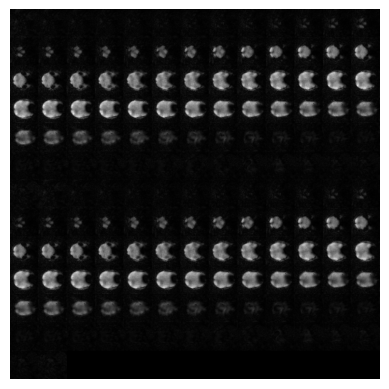

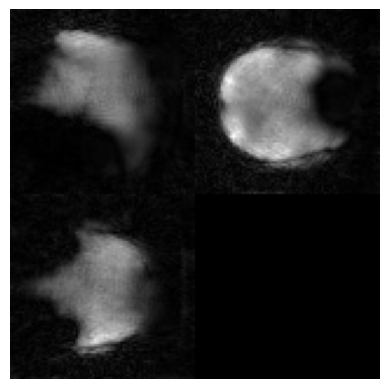

In [10]:
# visualize the results
from mirtorch.graph import tim
tim(x)
tim(x,viewtype='mid3')